# LoRa Data Analysis - Upper Confidence Bound


We first declare a fixed parameters.

Those parameters are not changed during the experiments.

Fixed communication parameters are listed below:
- Code Rate: 4/5
- Bandwidth: 125 kHz

End nodes:
- used an upper confidence bound (UCB) for communication parameters selection.

Access points:
- two access points were used to avoid a duty cycle depletion

Initial declaration

In [194]:
%matplotlib inline
import pandas as pd # import pandas
import numpy as np # import numpy
import matplotlib as mpl # import matplotlib
import matplotlib_inline as mpl_inl # import matplotlib
import matplotlib.pyplot as plt # import plotting module
import statistics
import math
import base64
from IPython.display import set_matplotlib_formats # module for svg export

mpl_inl.backend_inline.set_matplotlib_formats('svg') # set export to svg file
cut_ratio = 0.05 # Values below 5% of mean value are simply cut from charts to make it more readable
subfolder = 'data/s2'
uplink_message_file = './' + subfolder + '/uplink_messages.csv'
algorithm = 'ucb'

## Analysis of Uplink Messages

We read a csv file with uplink messages

In [195]:
uplink_data = pd.read_csv(uplink_message_file, delimiter=',')

Let us have a look at various columns that are present and can be evaluated.

In [196]:
uplink_data.head()

id      app_data   snr  rssi  duty_cycle_remaining is_primary  \
0  43122  QjVCQkJCAA==  8.50   -75                    31          t   
1  43123  QjVCQkJCAA==  8.00   -81                    29          f   
2  43124  QjVCQkJCAA==  9.00   -94                    31          f   
3  43125  QjVCQkJCAA==  8.50   -66                    29          t   
4  43126  QjVCQkJCAA==  9.25   -92                    31          f   

              receive_time    seq  frequency  spf  ...     airtime  coderate  \
0  2023-09-21 20:00:00.861  17020  866100000    7  ... -1185681856       4/7   
1  2023-09-21 20:00:00.862  17020  866100000    7  ... -1185681854       4/7   
2  2023-09-21 20:00:07.878  39736  866300000    7  ... -1185674857       4/7   
3  2023-09-21 20:00:07.879  39736  866300000    7  ... -1185674859       4/7   
4  2023-09-21 20:00:26.916  47394  866300000    7  ... -1185655707       4/7   

  bandwidth  msg_group_number  message_type_id   ap_id  node_id dev_id  \
0    125000               426                1  333333     ZmZm  43092   
1    125000               426                1  777777     ZmZm  43093   
2    125000               199                1  333333     qqqq  43094   
3    125000               199                1  777777     qqqq  43095   
4    125000               285                1  333333     iIiI  43096   

   application_id  battery  
0             NaN      NaN  
1             NaN      NaN  
2             NaN      NaN  
3             NaN      NaN  
4             NaN      NaN  

[5 rows x 21 columns]

Let us have a look for different values to get an overview of overall values of different network parameters.

In [197]:
uplink_data.describe()

id          snr         rssi  duty_cycle_remaining  \
count   8940.000000  8940.000000  8940.000000           8940.000000   
mean   47591.500000    10.329334   -82.249441          13728.174385   
std     2580.900037     2.720642    13.082448          11165.622398   
min    43122.000000   -17.000000  -119.000000              2.000000   
25%    45356.750000     9.250000   -93.000000           2800.000000   
50%    47591.500000    10.750000   -84.000000          12848.000000   
75%    49826.250000    11.750000   -77.000000          22950.000000   
max    52061.000000    20.500000   -48.000000          36000.000000   

                seq     frequency          spf   power       airtime  \
count   8940.000000  8.940000e+03  8940.000000  8940.0  8.940000e+03   
mean   30000.242729  8.663008e+08     8.786130     0.0 -1.151924e+09   
std    17529.740751  2.745242e+05     1.415837     0.0  1.935780e+07   
min      175.000000  8.661000e+08     7.000000     0.0 -1.185682e+09   
25%    16664.000000  8.661000e+08     8.000000     0.0 -1.168116e+09   
50%    29444.500000  8.661000e+08     9.000000     0.0 -1.153499e+09   
75%    42162.250000  8.665000e+08     9.000000     0.0 -1.135877e+09   
max    65353.000000  8.669000e+08    12.000000     0.0 -1.117507e+09   

       bandwidth  msg_group_number  message_type_id          ap_id  \
count     8940.0       8940.000000           8940.0    8940.000000   
mean    125000.0        863.631879              1.0  559581.841611   
std          0.0        415.167513              0.0  222197.939723   
min     125000.0        199.000000              1.0  333333.000000   
25%     125000.0        497.000000              1.0  333333.000000   
50%     125000.0        785.000000              1.0  777777.000000   
75%     125000.0       1211.000000              1.0  777777.000000   
max     125000.0       1791.000000              1.0  777777.000000   

             dev_id  application_id  battery  
count   8940.000000             0.0      0.0  
mean   47561.500000             NaN      NaN  
std     2580.900037             NaN      NaN  
min    43092.000000             NaN      NaN  
25%    45326.750000             NaN      NaN  
50%    47561.500000             NaN      NaN  
75%    49796.250000             NaN      NaN  
max    52031.000000             NaN      NaN

### Payload Length

In [198]:
uplink_data['payload_len'] = uplink_data.app_data.apply(len)
uplink_data.payload_len.describe()

count    8940.0
mean       12.0
std         0.0
min        12.0
25%        12.0
50%        12.0
75%        12.0
max        12.0
Name: payload_len, dtype: float64

In [199]:
payload_len = round(statistics.mean(uplink_data.payload_len), 2)
print(f'Mean value of payload length is {payload_len}.')

Mean value of payload length is 12.


### Spreading Factor

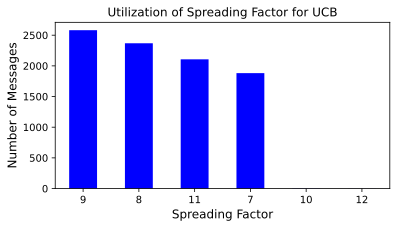

In [200]:
hist = uplink_data.spf.value_counts().plot(kind='bar',rot=0,color='b',figsize=(6,3))
hist.set_xlabel('Spreading Factor',fontsize=12)
hist.set_ylabel('Number of Messages',fontsize=12)

plt.title(f'Utilization of Spreading Factor for {algorithm.upper()}')
plt.savefig(f'./{subfolder}/{algorithm}-speading-factor.svg', dpi=300)
plt.show()

### Utilization of Frequency

Frequency is stored in Hz, so we need to convert it to MHz.

In [201]:
uplink_frequency = uplink_data.frequency / 1000000

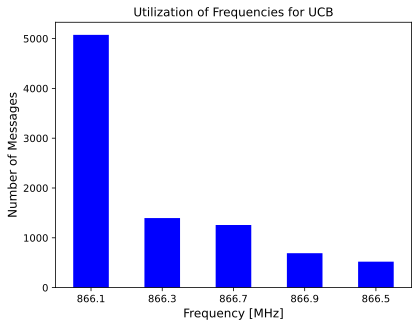

In [202]:
hist = uplink_frequency.value_counts().plot(kind='bar',rot=0,color='b')
hist.set_xlabel('Frequency [MHz]',fontsize=12)
hist.set_ylabel('Number of Messages',fontsize=12)

plt.title(f'Utilization of Frequencies for {algorithm.upper()}')
plt.savefig(f'./{subfolder}/{algorithm}-frequencies.svg', dpi=300)
plt.show()

### Transmission Power

### Received Signal Strength Indicator

In [203]:
x = uplink_data.id
y = uplink_data.rssi
hist.set_xlabel('Time', fontsize=12)
#hist.set_ylabel('Number of Messages', fontsize=12)

# size and color:
sizes = np.random.uniform(15, 80, len(x))

# Define the colormap 'Blues' which is a gradient of blue
cmap = plt.get_cmap('Blues')

# Define vmin and vmax values to control the gradient
vmin = 0.2
vmax = 0.8

# Generate random values within the range [vmin, vmax]
normalized_values = (np.random.rand(len(x)) * (vmax - vmin)) + vmin

fig, ax = plt.subplots()
sc = ax.scatter(x, y, s=sizes, c=normalized_values, cmap=cmap, vmin=vmin, vmax=vmax)

# Add colorbar for reference
cbar = plt.colorbar(sc)
cbar.set_label('Color Range')

ax.set_xticks([])

plt.title(f'RSSI values in time for {algorithm.upper()}')
plt.savefig(f'./{subfolder}/{algorithm}-rssi.svg', dpi=300)
plt.show()

### Different Types of Messages

Let us analyze the ratio of message types.

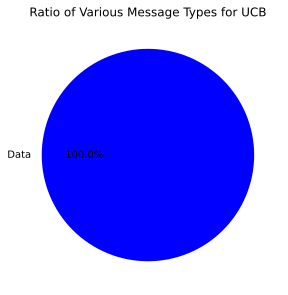

In [204]:
message_types = uplink_data.message_type_id.value_counts()

plt.pie(message_types, autopct='%1.1f%%', labels=['Data'], colors=['b', 'orange'])
plt.title(f'Ratio of Various Message Types for {algorithm.upper()}')

# Output is automatically exported
plt.savefig(f'./{subfolder}/{algorithm}-message-type.svg', dpi=300)
plt.show()

## Analysis of End Nodes

Analysis of certain aspects (active time, sleep time and collisions) of end devices.

In [205]:
print(f'Number of end nodes partiipating in the experiment is {uplink_data.node_id.nunique()}.')

Number of end nodes partiipating in the experiment is 10.


In [206]:
uplink_data.node_id.describe()

count     8940
unique      10
top       u7u7
freq      2405
Name: node_id, dtype: object

In [207]:
unique_ens = len(uplink_data.node_id.unique())
unique_aps = len(uplink_data.ap_id.unique())

print(f'Total number of connected end devices: {unique_ens}')
print(f'Total number of connected access points: {unique_aps}')

Total number of connected end devices: 10
Total number of connected access points: 2


### Ratio of Message Transmission Attempts to Successful Message Deliveries (MTAMD)

Evaluation of MTAMD for end nodes.

In [208]:
end_nodes = uplink_data.groupby('node_id')

seq_tolerance = 15
first_seq = 0
last_seq = 0
prev_seq = 0
prev_node_id = ""
msg_count = 0
msg_delivered = 0
total_msg_count = 0

for name,group in end_nodes:
    for seq in group['seq']:
        if (abs(prev_seq - seq) > seq_tolerance):
            total_msg_count += prev_seq - first_seq
            msg_delivered += msg_count
            first_seq = seq
            msg_count = 0
        if prev_seq != seq:
            msg_count += 1
        prev_seq = seq
        prev_node_id = name
    if total_msg_count != 0:
        pdr = round(msg_delivered / total_msg_count * 100, 2)
        print(f'{name} reached MTAMD {pdr}%')
    first_seq = 0
    last_seq = 0
    prev_seq = 0
    msg_count = 0
    msg_delivered = 0
    total_msg_count = 0


3d3d reached MTAMD 64.0%
VVVV reached MTAMD 56.88%
ZmZm reached MTAMD 63.08%
d3d3 reached MTAMD 64.17%
iIiI reached MTAMD 61.22%
mZmZ reached MTAMD 55.14%
qqqq reached MTAMD 65.88%
u7u7 reached MTAMD 57.88%
zMzM reached MTAMD 65.15%


The End.